In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optax

from jax import jit, vmap, random
import jax.numpy as jnp

from src.net import NeuralNetwork
from src.data import load_riser_data, get_X_y, split_curve

# Data

In [2]:
df_riser = load_riser_data('data/riser.csv')
df_riser

,psup,rgl,bsw,qliq,delta_p
0,10.0,50.000000,0.010000,300.0,98.266316
1,10.0,50.000000,0.061579,300.0,98.800564
2,10.0,50.000000,0.113158,300.0,99.743402
3,10.0,50.000000,0.164737,300.0,100.252045
4,10.0,50.000000,0.216316,300.0,101.191013
...,...,...,...,...,...
142982,60.0,585.897436,0.267895,6500.0,449.306072
142983,60.0,610.256410,0.010000,6500.0,432.506369
142984,60.0,610.256410,0.061579,6500.0,438.928311
142985,60.0,610.256410,0.113158,6500.0,445.509859


In [3]:
df_train, df_test = split_curve(df_riser, 0.5)
df_train.shape, df_test.shape

((9068, 5), (133911, 5))

# ReLU

## Medium

In [4]:
X_train, y_train = get_X_y(df_train)
X_test, y_test = get_X_y(df_test)

In [5]:
X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_train.shape, y_train.shape

((9068, 4), (9068, 1))

/home/bruno/miniconda3/envs/relu/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


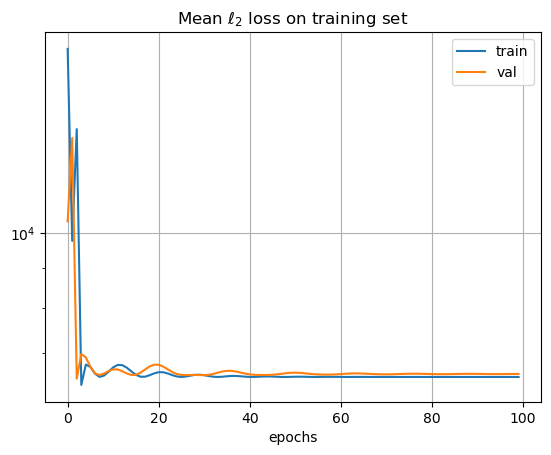

Test performance
MAE = 94.15921
max error = 323.05103


In [6]:
net = NeuralNetwork(random_key=1, learning_rate=1e-1, epochs=100)

net = net.fit(
    X_train, y_train,
    X_val=X_test, y_val=y_test,
)

plt.plot(net.train_loss_values_, label='train')
plt.plot(net.val_loss_values_, label='val')
plt.yscale('log')
plt.xlabel('epochs')
plt.title('Mean $\ell_2$ loss on training set')
plt.legend()
plt.grid()
plt.show()

y_hat = net.predict(X_test)

df_test['delta_p_hat'] = y_hat

err = y_hat[:,0] - df_test['delta_p'].values

print('Test performance')
print('MAE =', np.abs(err).mean())
print('max error =', np.abs(err).max())

In [7]:
import pickle
with open('test.pkl', 'wb') as f:
    pickle.dump(net, f)

PicklingError: Can't pickle <function _predict at 0x7fada81cdc60>: it's not the same object as src.net._predict

In [8]:
y_hat = predict(X_train)

df_train['delta_p_hat'] = y_hat

err = y_hat[:,0] - df_train['delta_p'].values

print('Training performance')
print('MAE =', np.abs(err).mean())
print('max error =', np.abs(err).max())

Training performance
MAE = 94.29659
max error = 321.31525


In [9]:
y_hat = predict(X_test)

df_test['delta_p_hat'] = y_hat

err = y_hat[:,0] - df_test['delta_p'].values

print('Test performance')
print('MAE =', np.abs(err).mean())
print('max error =', np.abs(err).max())

Test performance
MAE = 94.19582
max error = 322.8239


## Curves

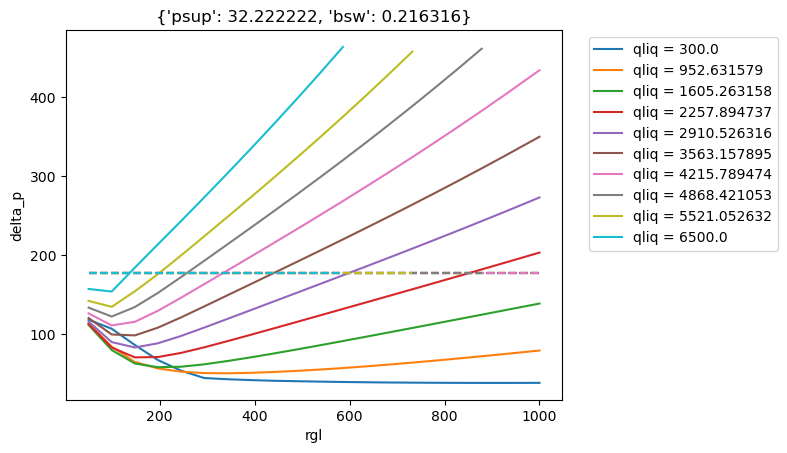

In [12]:
fixed_point = {
    'psup': 32.222222,
    'bsw': 0.216316,
}

df_ = df_train[(df_train['psup'] == fixed_point['psup']) & (df_train['bsw'] == fixed_point['bsw'])]

for val in df_['qliq'].unique():
    df__ = df_[df_['qliq'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"qliq = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

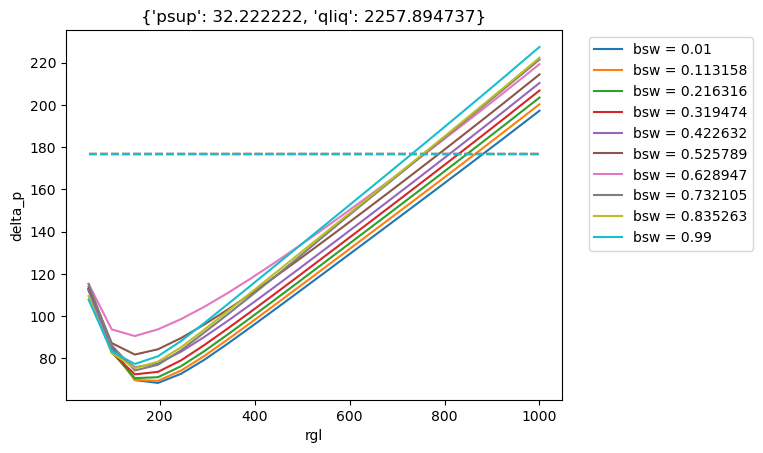

In [13]:
fixed_point = {
    'psup': 32.222222,
    'qliq': 2257.894737,
}

df_ = df_train[(df_train['psup'] == fixed_point['psup']) & (df_train['qliq'] == fixed_point['qliq'])]

for val in df_['bsw'].unique():
    df__ = df_[df_['bsw'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"bsw = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

In [167]:
X_train

DeviceArray([[0.        , 0.        , 0.        , 0.        ],
             [0.        , 0.        , 0.10526326, 0.        ],
             [0.        , 0.        , 0.21052653, 0.        ],
             ...,
             [1.        , 0.5641026 , 0.10526326, 1.        ],
             [1.        , 0.5641026 , 0.21052653, 1.        ],
             [1.        , 0.61538464, 0.        , 1.        ]],            dtype=float32)

In [166]:
X_train - X_train.max(0)

DeviceArray([[-1.        , -1.        , -1.        , -1.        ],
             [-1.        , -1.        , -0.89473677, -1.        ],
             [-1.        , -1.        , -0.7894735 , -1.        ],
             ...,
             [ 0.        , -0.4358974 , -0.89473677,  0.        ],
             [ 0.        , -0.4358974 , -0.7894735 ,  0.        ],
             [ 0.        , -0.38461536, -1.        ,  0.        ]],            dtype=float32)

# PWL

In [65]:
from src.pwl import PWL

In [72]:
model = PWL()
model.fit(df_train)

y_hat = model(df_train)

assert (df_train['delta_p'].values == y_hat).all()
assert not np.isnan(y_hat).any()

In [73]:
%time y_hat = model(df_test)

np.isnan(y_hat).sum() / len(y_hat)

CPU times: user 1.19 s, sys: 265 ms, total: 1.46 s
Wall time: 38.4 s


0.0291387563381649

In [84]:
err = df_test['delta_p'].values - y_hat
err = err[~np.isnan(err)]

print('Test performance')
print('MAE =', np.abs(err).mean())
print('max error =', np.abs(err).max())

Test performance
MAE = 0.9048608879326693
max error = 19.759507918489533
